## Zillow 2017 predictions report:

Got an email from the Zillow DS Team:

<i>"We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.

We have a model already, but we are hoping your insights can help us improve it. I need recommendations on a way to make a better model. Maybe you will create a new feature out of existing ones that works better, try a non-linear regression algorithm, or try to create a different model for each county. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in."</i>

-- The Zillow Data Science Team

___________________________________________________________________________________________________________________

## My Goal: to predict the values of single unit properties using the zillow database obervations from 2017.




### My Deliverables:

- Constructed ML Regression model that predicts propery tax assessed values (and can be used for our marketing and tech departments).

- Finding the key drivers of property value for single family properties. 


### My Questions: 

- Why are some properties with similar features valued so differently? 

- Do count of bath/bedrooms drive the property value? And if so, is there one more weighted against the other?

- Is there a difference of the average of property values by county? And if so, what is the difference?


### Follow up Questions:

- Can we get data on the population income average per county?

- Can we get the data on school ratings (greatschools.com) and see if this might be a main driver as well?

- Can we gather predictions and data based on other location factors (ie parks, hiking, waterfronts, nearby churches, grocery stores, malls, etc)





In [1]:
#will insert and collect needed imports to repo along the workflow, down below:

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
from env import get_db_url
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from acquire import wrangle_zillow


### Acquistion: 
INITIAL ACQUISITION:
We will be calling in the zillow dataset from the MySQL database.
This dataset will only with include taxvaluedollarcnt, bathroom count, bedroom count, calculatedfinishedsquarefeet, transactiondate and fips.

This dataset will also only take in transaction accounts from year 2017. 

In [3]:
# Using MySQL, we will Find all of the "Single Family Residential" properties and transactions from 2017:
df = pd.read_sql("SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, transactiondate, fips FROM properties_2017 JOIN predictions_2017 AS pe USING (parcelid) JOIN propertylandusetype USING (propertylandusetypeid) WHERE propertylandusetype.propertylandusedesc = 'Single Family Residential' AND pe.transactiondate LIKE '2017%%';", get_db_url("zillow"))
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips
0,3.0,1.0,1012.0,79904.0,2017-01-13,6037.0
1,4.0,2.0,1242.0,590000.0,2017-01-13,6037.0
2,2.0,1.0,864.0,355000.0,2017-01-13,6037.0
3,3.0,2.0,1550.0,2200000.0,2017-01-13,6037.0
4,3.0,2.0,1149.0,185716.0,2017-01-13,6037.0


### Acquistion Summary: 
Getting to know the data in dtypes, and any missed nulls from prep


In [4]:
#noting that transactiondate is the only non-numeric column. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedfinishedsquarefeet  52359 non-null  float64
 3   taxvaluedollarcnt             52440 non-null  float64
 4   transactiondate               52441 non-null  object 
 5   fips                          52441 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.4+ MB


In [5]:
#looking at the counts for each column
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-------------------------------")

bedroomcnt
3.0     23359
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedroomcnt, dtype: int64
-------------------------------
bathroomcnt
2.0     21893
3.0     10673
1.0      9568
2.5      3934
4.0      2227
3.5       918
1.5       841
5.0       803
4.5       687
6.0       322
5.5       224
0.0       121
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathroomcnt, dtype: int64
-------------------------------
calculatedfinishedsquarefeet
1120.0    128
1200.0    119
1080.0    102
936.0      86
1040.0     86
         ... 
4207.0      1
3694.0      1
4773.0      1
9848.0      1
5124.0      1
Name: calculatedfinishedsquarefeet, Length: 4723, dtype: int64
-------------------------------
taxvaluedollarcnt
455000.0    34
600000.0    30
550000.0    24
45000

In [6]:
#Let's check for any nulls
df.isnull().sum()

bedroomcnt                       0
bathroomcnt                      0
calculatedfinishedsquarefeet    82
taxvaluedollarcnt                1
transactiondate                  0
fips                             0
dtype: int64

In [7]:
#If these nulls are dropped, will it effect the dataset?
round(df.dropna().shape[0] / df.shape[0], 4)

0.9984

### Prep-Clean:

In [8]:
#99% of our data still left? Great! Let's drop them!
df = df.dropna()
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
transactiondate                 0
fips                            0
dtype: int64

#### Convert Datatyes

- I'll be changing bedroomcnt, finishedsquareft, taxvaluedollar, and fips into integers so as to utilize in continuous testing. 

- I will not change bathroomcnt due to some objects showing 1/2 baths.

- I will not change transaction date as it already is in the format I want. 

In [9]:
##Changing dtype of Fips code so only 4 digits (no decimals)
df['fips'] = df['fips'].astype('int')

In [10]:
#Changing dtype of squarefeet so no decimals
df['calculatedfinishedsquarefeet'] = df['calculatedfinishedsquarefeet'].astype('int')

In [11]:
#Changing dtype of taxvaluedollarcnt as integer
df['taxvaluedollarcnt'] = df['taxvaluedollarcnt'].astype('int')

In [12]:
#changing bedroom count to int
df['bedroomcnt']= df['bedroomcnt'].astype('int')

In [13]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips
0,3,1.0,1012,79904,2017-01-13,6037
1,4,2.0,1242,590000,2017-01-13,6037
2,2,1.0,864,355000,2017-01-13,6037
3,3,2.0,1550,2200000,2017-01-13,6037
4,3,2.0,1149,185716,2017-01-13,6037


### Exploration and Visualization (looking at the data):

In [14]:
#taking a look at the mean and other data stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,52358.0,3.305531,0.941429,0.0,3.00,3.0,4.00,14.0
bathroomcnt,52358.0,2.302781,1.019773,0.0,2.00,2.0,3.00,18.0
calculatedfinishedsquarefeet,52358.0,1922.904618,1004.370420,128.0,1268.00,1659.0,2306.00,21929.0
taxvaluedollarcnt,52358.0,528025.819569,748329.465813,1000.0,193644.25,373376.5,618533.25,49061236.0
fips,52358.0,6049.111158,21.019623,6037.0,6037.00,6037.0,6059.00,6111.0


<AxesSubplot:>

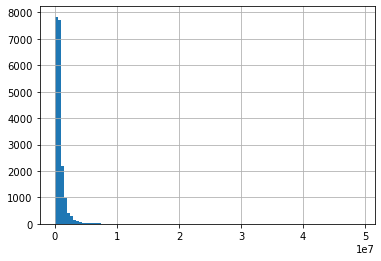

In [15]:
#looking at 100 properties where bathroom count is higher than average
df[df.bathroomcnt > 2.3].taxvaluedollarcnt.hist(bins=100)

<AxesSubplot:>

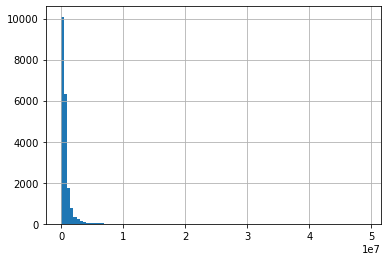

In [16]:
#looking at 100 properties where bedroom count is higher than average

df[df.bedroomcnt > 3.3 ].taxvaluedollarcnt.hist(bins=100)

#### More Visualizations

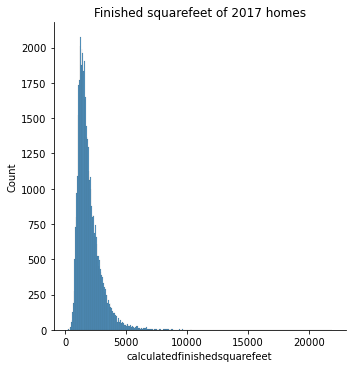

In [17]:
#using sns displot to see values of homes and the years built 
sns.displot(x='calculatedfinishedsquarefeet', data=df)

plt.title('Finished squarefeet of 2017 homes')
plt.show()

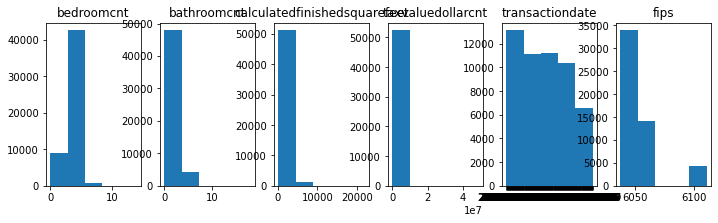

In [18]:
#creating histograms for all the variables

plt.figure(figsize=(16, 3))

# Creates a List of columns:
for i, col in enumerate(df.columns):

    # i starts at 0, but plot numbers should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,8, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

#### Takeaways:
Just these few visuals show me there are some outliers that need to be dropped

### Handling Outliers:
Seeing the size and count of the variables to locate any outliers

#### Squarefootage:

In [19]:
df.calculatedfinishedsquarefeet.sort_values(ascending=False).head(15)

2174     21929
14539    20612
7316     18654
48813    17245
27077    15450
41548    14829
28165    13598
16552    12616
48263    12056
4249     12039
5647     11880
46706    11722
22190    11704
3754     11703
11641    11649
Name: calculatedfinishedsquarefeet, dtype: int64

I'm thinking of narrowing down to only a range of below 9,000sqft homes

In [20]:
#let's see the percentage if we narrowed it down from there
df[df.calculatedfinishedsquarefeet <= 9_000].shape[0] / df.shape[0]


0.9989304404293518

I still would have 99.8% of my data. I feel comfortable narrowing things down to this.


In [21]:
 df = df[df.calculatedfinishedsquarefeet <= 9_000]

Let's look at the lower sqft end:

In [22]:
df[df.calculatedfinishedsquarefeet >= 200].shape[0] / df.shape[0]

0.9999617605445299

Again, I feel comfortable narrowing from this end too:

In [23]:
df = df[df.calculatedfinishedsquarefeet >= 200]

#### Bedroom Count:

In [24]:
df.bedroomcnt.sort_values(ascending=False).head(15)

31642    12
31641    12
31643    12
21165    11
33907    10
28209     9
49355     9
44252     9
6425      9
11416     9
5291      9
1695      8
47881     8
36666     8
7035      8
Name: bedroomcnt, dtype: int64

Hmm...what if I get rid of homes with more than 6 bedrooms?

In [25]:
df[df.bedroomcnt <= 6].shape[0] / df.shape[0]

0.9976099426386233

In [26]:
#that looks good:
df = df[df.bedroomcnt <= 6]

I also will get rid of zero bedrooms as my industry source says these are similar to nulls:

In [27]:
df[df.bedroomcnt != 0].shape[0] / df.shape[0]

0.9988116914230953

In [28]:
#yep, still leaves us with 99.8%
df=df[df.bedroomcnt != 0]

#### Bathroom Count

In [29]:
df.bathroomcnt.sort_values(ascending=False).head(15)

12619    9.0
38176    9.0
17246    9.0
19961    8.5
4254     8.0
46327    8.0
11189    8.0
7056     8.0
4925     8.0
6686     8.0
39768    8.0
12548    8.0
34869    8.0
29198    8.0
44788    8.0
Name: bathroomcnt, dtype: float64

ok. Maybe let's see how much data is left with 6 or less baths?

In [30]:
df[df.bathroomcnt <= 6].shape[0] / df.shape[0]

0.9970256941646038

In [31]:
#cool, let's narrow it here too:
df = df[df.bathroomcnt <= 6]

In [32]:
#also getting rid of properties with no baths
df=df[df.bathroomcnt != 0]

In [33]:
#Let's see how much data we have still....
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51942 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51942 non-null  int64  
 1   bathroomcnt                   51942 non-null  float64
 2   calculatedfinishedsquarefeet  51942 non-null  int64  
 3   taxvaluedollarcnt             51942 non-null  int64  
 4   transactiondate               51942 non-null  object 
 5   fips                          51942 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.8+ MB


In [34]:
#looking at the counts for each column
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-------------------------------")

bedroomcnt
3    23351
4    15218
2     8334
5     3891
1      605
6      543
Name: bedroomcnt, dtype: int64
-------------------------------
bathroomcnt
2.0    21879
3.0    10644
1.0     9544
2.5     3932
4.0     2203
3.5      915
1.5      840
5.0      786
4.5      679
6.0      297
5.5      223
Name: bathroomcnt, dtype: int64
-------------------------------
calculatedfinishedsquarefeet
1120    127
1200    118
1080    102
1040     86
936      86
       ... 
4128      1
4482      1
6571      1
5322      1
5124      1
Name: calculatedfinishedsquarefeet, Length: 4489, dtype: int64
-------------------------------
taxvaluedollarcnt
455000    34
600000    30
500000    24
450000    24
550000    24
          ..
159489     1
161962     1
317075     1
635345     1
33325      1
Name: taxvaluedollarcnt, Length: 38507, dtype: int64
-------------------------------
transactiondate
2017-06-30    802
2017-04-28    610
2017-05-31    559
2017-07-28    540
2017-08-31    522
             ... 
2017-08-13     

#### Assessed Value of Home:
Let's see what outliers are here...

In [35]:
df.taxvaluedollarcnt.sort_values(ascending=False).head(15)

50749    20203475
39015    15618488
48383    13600098
8195     13198250
31892    13128583
34899    11317682
36239    11020600
43578    11000000
38704    10873908
3771     10610405
50762    10355345
24259    10130485
50475    10050974
41562     9935000
37553     9870514
Name: taxvaluedollarcnt, dtype: int64

Wow. Maybe I'll see what it looks like for 2M homes or less...

In [36]:
df[df.taxvaluedollarcnt <= 2_000_000].shape[0] / df.shape[0]

0.9771475876939664

In [37]:
#I'll try a little bit more, to get to 98 or 99% still left
df[df.taxvaluedollarcnt <= 2_500_000].shape[0] / df.shape[0]

0.9861961418505256

Yep. Let's take these outliers out too

In [38]:
df = df[df.taxvaluedollarcnt <= 2_500_000]

In [39]:
#other end:
df[df.taxvaluedollarcnt >= 45_000].shape[0] / df.shape[0]

0.9808882381649585

I don't know who is buying these homes at 45,000, but good for them...and I'm taking out the lower end ones

In [40]:
df = df[df.taxvaluedollarcnt >= 45_000]

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50246 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    50246 non-null  int64  
 1   bathroomcnt                   50246 non-null  float64
 2   calculatedfinishedsquarefeet  50246 non-null  int64  
 3   taxvaluedollarcnt             50246 non-null  int64  
 4   transactiondate               50246 non-null  object 
 5   fips                          50246 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.7+ MB


____________________________________________________________________________________________________________

### Missing county/fips codes in:
Thanks Zach for losing those fip codes! ;) 
Here is a function to add those back in.

In [42]:
def clearing_fips(df):
    '''This function takes in a DataFrame of unprepared Zillow information and generates a new
    'county' column, with the county name based on the FIPS code. 
    '''
    # create a list of our conditions
    fips = [
        (df['fips'] == 6037),
        (df['fips'] == 6059),
        (df['fips'] == 6111)
        ]
    # create a list of the values we want to assign for each condition
    counties = ['Los Angeles County', 'Orange County', 'Ventura County']
    # create a new column and use np.select to assign values to it using our lists as arguments
    df['county'] = np.select(fips, counties)
    return df

In [43]:
clearing_fips(df)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county
0,3,1.0,1012,79904,2017-01-13,6037,Los Angeles County
1,4,2.0,1242,590000,2017-01-13,6037,Los Angeles County
2,2,1.0,864,355000,2017-01-13,6037,Los Angeles County
3,3,2.0,1550,2200000,2017-01-13,6037,Los Angeles County
4,3,2.0,1149,185716,2017-01-13,6037,Los Angeles County
...,...,...,...,...,...,...,...
52435,4,2.0,1440,585000,2017-09-06,6059,Orange County
52436,4,2.0,1669,569544,2017-09-06,6059,Orange County
52437,3,2.0,1821,402132,2017-09-06,6037,Los Angeles County
52438,2,1.0,1246,468691,2017-09-06,6037,Los Angeles County


### >>ALL THE ABOVE IS NOW ADDED INTO THE ACQUIRE .py file<<

_____________________________________________________________________________________________________________________

In [44]:
#LET's check out that acquire.py file!


### Exploration and Test:

In [45]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x="Bedroom_Count", y="square_feet")

ValueError: Could not interpret value `Bedroom_Count` for parameter `x`

<Figure size 720x576 with 0 Axes>